# Climate Change Exploration: Manalua Bay Region, Hawai'i
## Fall 2021
### Elmera Azadpour
All scripts and data can be accessed from: 
https://github.com/aloha-aina/Aloha-Aina-Master

In [1]:
## import libraries:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
import s3fs
import kedro
import nc_time_axis

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
## browse CMIP6 Public Data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ua,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,va,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,vas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
## filter to find monthly surface air temperature for historical experiments
df_ta = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9474,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
10522,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701
13745,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22537,CMIP,IPSL,IPSL-CM6A-LR,historical,r11i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
22577,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
...,...,...,...,...,...,...,...,...,...,...,...
520151,CMIP,MRI,MRI-ESM2-0,historical,r9i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210813
520178,CMIP,MRI,MRI-ESM2-0,historical,r7i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210813
520246,CMIP,MRI,MRI-ESM2-0,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20210907
520489,CMIP,CMCC,CMCC-CM2-SR5,historical,r3i1p2f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...,NaN,20211108


In [4]:
## filtering to find just the models from NCAR
df_ta_ncar = df_ta.query('institution_id == "NCAR"')
df_ta_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
56137,CMIP,NCAR,CESM2-WACCM,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56219,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
56224,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
58847,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
59068,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
59371,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
60142,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61106,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
62996,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
64909,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311


In [5]:
## load data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.zstore.values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historical/r2i1p1f1/Amon/tas/gn/v20200226/


<xarray.Dataset>
Dimensions:    (lat: 96, nbnd: 2, lon: 144, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(990, 96, 144), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           10950.0
    ...                              ...
    tracking_id:                     hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    variable_id:                     tas
    variant_info:                    CMIP6 CESM2-FV2 historical experiment (1...
    variant_label:                   r2i1p1f1
    netcdf_tracking_ids:             hdl:21.14100/99cdfde8-5b6d-452b-9b78-62a...
    version_id:                      v20200226

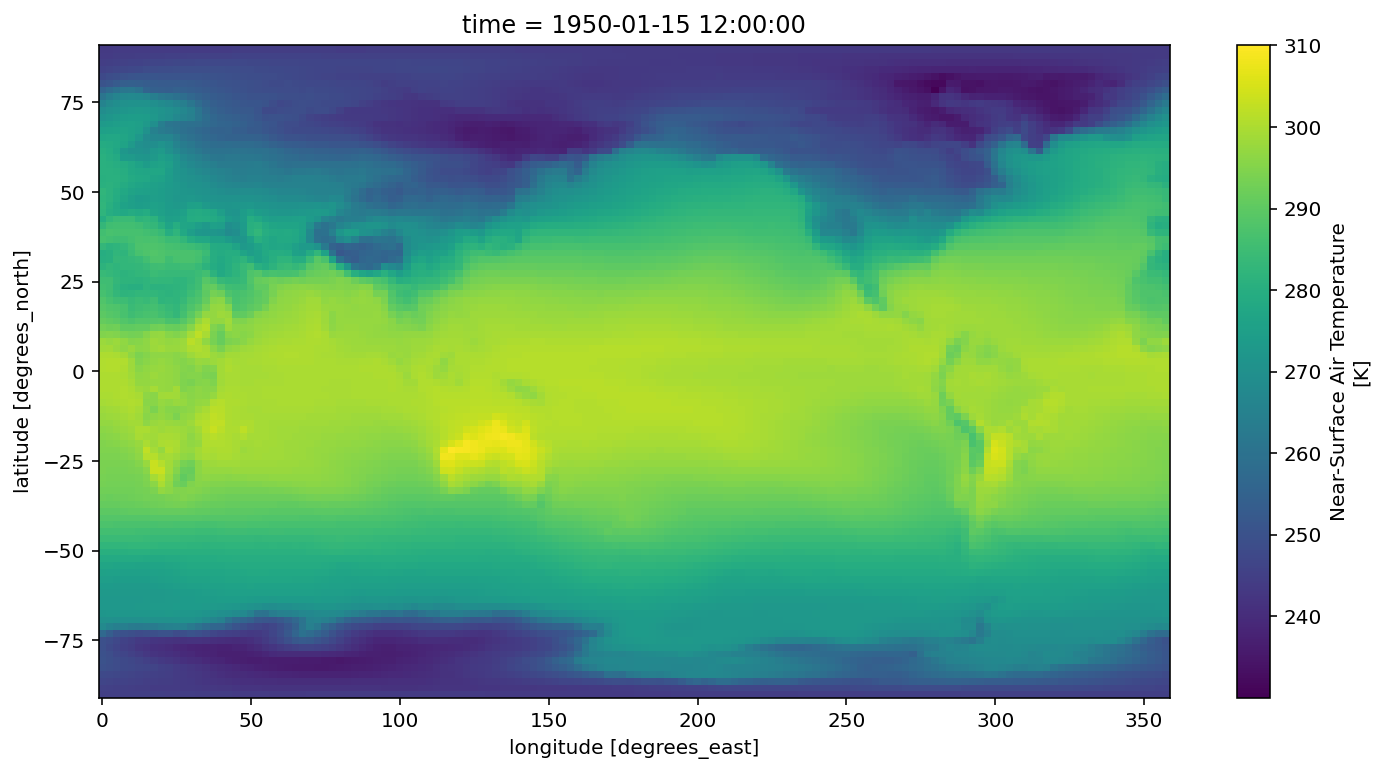

In [6]:
## Plot a map from a specific date.
ds.tas.sel(time='1950-01').squeeze().plot()


In [7]:
## timeseries of global-average surface air temperature.
## need the area weighting factor for each gridpoint.
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          no parent
    branch_time_in_child:   711385.0
    branch_time_in_parent:  0.0
    case_id:                38
    ...                     ...
    variable_id:            areacella
    variant_info:           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001 
\n
\...
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/23fa9dc3-4f8f-4943-b99b-58eb804c06f0
    version_id:             v20190218

In [8]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(990,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [9]:
%time ta_timeseries.load() ## data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

CPU times: user 619 ms, sys: 346 ms, total: 965 ms
Wall time: 5.05 s


<xarray.DataArray (time: 1980)>
array([0.00407822, 0.00405088, 0.0039282 , ..., 0.00411686, 0.00414686,
       0.00418852], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

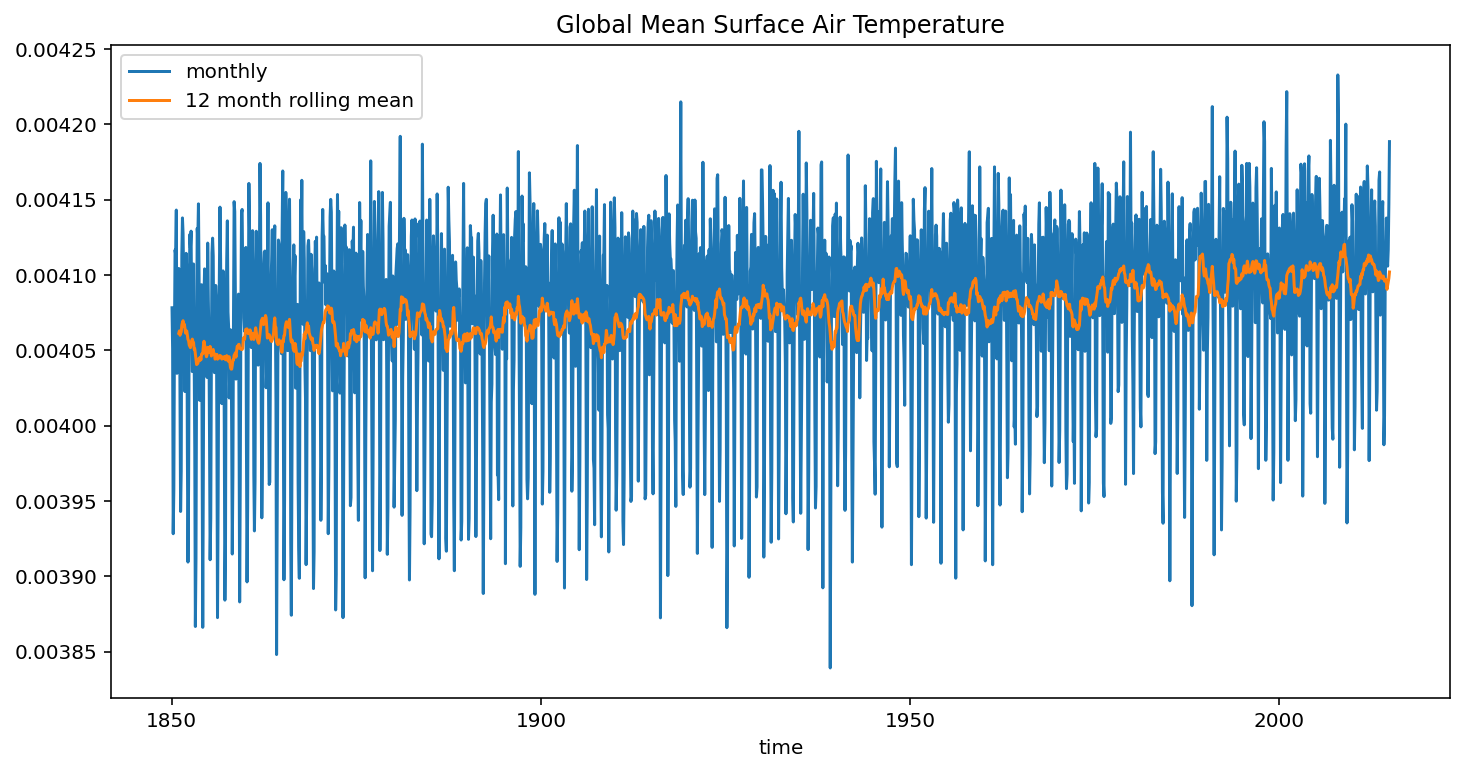

In [11]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

### Let's focus in on Hawaii now

In [20]:
# Create logical masks for lat and lon variables
mask_lon = (ds.tas.lon >= 21.2) & (ds.tas.lon <= 21.8)
mask_lat = (ds.tas.lat >= -158.4) & (ds.tas.lat <= -157.6)
mask_lat
# Apply lat/lon masks to the ERSST field, then calculate averages over the lat and lon dimensions
oahu_ts=ds.tas.where(mask_lon & mask_lat).mean("lon").mean("lat")
oahu_ts

<xarray.DataArray 'tas' (time: 1980)>
dask.array<mean_agg-aggregate, shape=(1980,), dtype=float32, chunksize=(990,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00